# Practical Data Science - Project Final Report
### Topic: Stock Market Data Exploration and Prediction
__Authors__: Yanxing Feng, Richie Varghese, Zhining Zhou

## Motivation

Predicting stock prices and trends to some degree of accuracy is highly valuable. There are multiple potential approaches available to address problems of this type. We want to explore and compare them in this project.

## Primary Objectives

* Discover underlying trends within different industries and across these industries by exploring historical data.
* Use 6 different models to see which one performs better in predicting trends and prices.


In [0]:
import requests
import csv
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
from datetime import timedelta,date
import time
import seaborn as sns
import collections
warnings.filterwarnings('ignore')
from os import walk
import glob
import numpy as np



## Data Pipeline Overview

We performed the following steps to explore stock market dataset and benchmark different predictive models <br>

1. Data Requesting from API
2. Data Preprocessing & Aggregation
3. Exploratary Data Analysis
4. Predictive Model Pipeline Building
5. Model Performance Benchmarking for Top Stocks of each 
<img src="https://github.com/kenny4088/PDS/blob/master/Images/Pipe.png?raw=true"/>

## Data Acquisition

We acquired stock data from an API called [Alpha Vantage](https://www.alphavantage.co/#page-top), which is a leading provider of free APIs for realtime and historical data on stocks, forex (FX), and digital/crypto currencies. Our success is driven by rigorous research, cutting edge technology, and a disciplined focus on democratizing access to data.

We choose this API for the following reasons:
<br>
 * It covers all public companies' stock price data.
 * The time range coverage for each stock is wide (Almost all data for each stock).
 * It supports `.csv` as the response format.
 * Most importantly, it's free ! :)
 
The following function __`download_stock`__ will request all the stock price data from [Alpha Vantage API](https://www.alphavantage.co/#page-top). Due to traffic limit of the API, we set the interval between requests as __15__ seconds


In [0]:
def download_stock(stock_code,API_key):
    if os.path.exists('data/{}.csv'.format(stock_code)):
        return
    url = "https://www.alphavantage.co/query\?function=TIME_SERIES_DAILY&symbol={0}&outputsize=full&apikey={1}&datatype=csv".format(stock_code,API_key)
    try:
        r = requests.get(url, allow_redirects=True)
        open('data/{}.csv'.format(stock_code), 'wb').write(r.content)
        time.sleep(15)
    except:
        print(stock_code)

Requesting data for companies in ___S&P 500___ listing. All csv files will be stored in the `Data/` Folder

In [0]:
# We applied for two API keys:
# 'TTKT2K6JDYK8U0G1' 
# 'ZL2U2GSDBJ8K57I6'
API_key ='TTKT2K6JDYK8U0G1'
sp500 = pd.read_csv('SP500.csv')
os.makedirs('data')
for stock in sp500.Symbol:
    download_stock(stock,API_key)

## Data Preprocessing and Aggregating based on Industries

We use two files - `S&P 500 Weights.csv` and `S&P 500 Industries.csv` to map which stock belongs to which industry and to map the associated weight in the S&P 500 index calculation. We use these indices to calculate the total weight of each industry in the S&P 500 index which is shown as output below.


In [0]:
mypath="./Data"
outputdir="./Industries"
weights_file = "./S&P 500 Weights.csv"
industries_file = "./S&P 500 Industries.csv"
files = []

weights_df = pd.read_csv(weights_file)
weights_dict = pd.Series(weights_df.Weight.values, index=weights_df.Symbol).to_dict()

industries_df = pd.read_csv(industries_file)
industries_dict = pd.Series(industries_df['GICS Sector'].values, index=industries_df.Symbol).to_dict()

reverse_industries_dict = {}

for key, val in industries_dict.items():
    if val in reverse_industries_dict:
        reverse_industries_dict[val].append(key)
    else:
        reverse_industries_dict[val] = [key]

# print(reverse_industries_dict)

for key, val in reverse_industries_dict.items():
    total = 0
    for comp in val:
        total += weights_dict[comp]
    print(key, total)
        
        
data_dict = {}

if not os.path.exists(outputdir):
    os.makedirs(outputdir)

for (dirpath, dirnames, filenames) in walk(mypath):
    for f in filenames:
        try:
            df = pd.read_csv(dirpath+'/'+f)
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df = df.set_index('timestamp')
#             print(df.open)
            data_dict[f[:-4]]=df
        except:
            print("Parsing Error in",f[:-4])

Industrials 9.422666999999997
Health Care 13.841583
Information Technology 22.614822000000004
Consumer Discretionary 9.822768999999997
Utilities 3.320673
Financials 13.112253000000003
Materials 2.719782
Real Estate 2.9979500000000003
Energy 4.348743


This function allows us to loop over every day from a given `start_date` to an `end_date`.

In [0]:
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

We then calculate a daily `price` and `volume` for each industry by computing a weighted average over the price and volume for every stock within that industry based on the weights associated for that stock as mentioned above. After running the subsequent cell, we will have `price` and `volume` values for each day and for each industry in industry specific dataframes. These dataframes will act as the basis of our exploratory data analysis in the next section.

In [0]:
industry_data = {}
for key, val in reverse_industries_dict.items():
    ind_df = pd.DataFrame(columns=['timestamp','open','high','low','close','volume'])
    start_date = date(1999, 11, 15)
    end_date = date(2019, 11, 16)
    i = 0
    for single_date in daterange(start_date, end_date):
        denom = 0
        for comp in val:
            if comp!='GL' and single_date in data_dict[comp].index:
                denom += weights_dict[comp]
        openval = 0
        highval = 0
        lowval = 0
        closeval = 0
        volume = 0
        exists = False
        for comp in val:
            if comp!='GL' and single_date in data_dict[comp].index:
                exists = True
                df = data_dict[comp]
                row = df.loc[single_date]
                weight = weights_dict[comp]/denom
                openval += row['open']*weight
                highval += row['high']*weight
                lowval += row['low']*weight
                closeval += row['close']*weight
                volume += row['volume']
        if exists:
            ind_df.loc[i] = [single_date.strftime("%m-%d-%Y"), openval, highval, lowval, closeval, volume]
            i += 1
    print(key)
    industry_data[key] = ind_df    

Industrials
Health Care
Information Technology
Consumer Discretionary
Utilities
Financials
Materials
Real Estate
Energy


We store these industry specific dataframes into individual `CSV` files.

In [0]:
for key, val in industry_data.items():
    val.to_csv(outputdir+"/"+key+".csv", index = False)

We create a list of stocks that have data for all the days we are interested in i.e `15th Nov 2013` to `15th Nov 2019`. We use this list of stocks later in the prediction part.

In [0]:
model_inputs = []
for key, val in data_dict.items():
    if '2013-11-15' in val.index and '2019-11-15' in val.index:
        model_inputs.append(key)

## Exploratory Data Analysis
We performed data analysis based on company-level data and industry-level data. 

* For company-level data, we investigated the correlation between stock pairs, conducted time series trend analysis for individual stocks, as well as calculated stock returns.

* For industry-level data, we specifically considered the correlation between different industries.

Read all stocks from csv

In [0]:
def getData(filename):
    df = pd.read_csv(filename[0])
    stockname = filename[0].split("Data/")[1].split('.csv')[0]
    s = df[['timestamp', 'close']]
    s = s.rename(columns={'close':stockname})
    for i in range(1, len(filename)):
        df = pd.read_csv(filename[i])
        stockname = filename[i].split("Data/")[1].split('.csv')[0]
        data = df[['timestamp', 'close']]
        data = data.rename(columns={'close':stockname})
        s = pd.merge(s, data, on='timestamp', how='outer')
    s.set_index('timestamp', inplace=True)
    s = s.sort_index()
    return s

In [0]:
filename = glob.glob("./Data/*.csv")
stocks = getData(filename)

After reading all the data, we are interested to find if individual stocks correlate with each other. In our cases, we print top 50 correlation pairs with the correlation coefficient.

We could see that for the top 50 correlation pairs, the absolute value of correlation coefficient is very large (greater than 0.98). This suggest that either stocks are in the same industry or they are in the opposite industry.

In [0]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs.add((cols[i], cols[j]))
    return pairs

def get_top_correlations(df, n=5):
    corr = df.corr().abs().unstack()
    to_drop = get_redundant_pairs(df)
    corr = corr.drop(labels=to_drop).sort_values(ascending=False)
    return corr[0:n]

In [0]:
top_corr = get_top_correlations(stocks, n=50)


top50 = pd.DataFrame(columns=['col1', 'col2', 'corr'])

for i in top_corr.index:
    cor = stocks[i[0]].corr(stocks[i[1]])
    top50.loc[-1] = [i[0], i[1], cor]
    top50.index = top50.index + 1  # shifting index
    top50 = top50.sort_index()  

top50

,col1,col2,corr
0,FRT,SPG,0.985151
1,NEE,AWK,0.985263
2,CINF,AWK,0.985272
3,AON,MTD,0.985286
4,PYPL,PGR,0.985315
5,ZTS,CDW,0.985321
6,PGR,MSCI,0.985392
7,SHW,TMO,0.985418
8,ZTS,MSCI,0.985470
9,MSCI,CDW,0.985727


Correlation between companies with maximum market share in each industry
* We aggragate the data by 'GICS Sector', which defines the industry that each stock belongs to. 
* For each company with the maximum market share, we compute the correlation between those stocks again. We assume that they could be a good intepretation of how industries correlate with each other.

In [0]:
st = glob.glob("./*.csv")
df1 = pd.read_csv(st[0])
df2 = pd.read_csv(st[1])
tmp = pd.merge(df1, df2, on='Symbol')[['Symbol', 'Weight', 'GICS Sector']]

def get_max_weight_sector(df):
    res = df.groupby('GICS Sector')['Weight'].max()
    company = []
    sectors = []
    for sector in res.index:
        tmp = df[df['GICS Sector'] == sector]
        maxW = res[sector]
        sectors.append(sector)
        company.append(tmp[tmp['Weight'] == maxW]['Symbol'].values[0])
        print(tmp[tmp['Weight'] == maxW]['Symbol'].values[0])

    return company, sectors

In [0]:
company, sectors = get_max_weight_sector(tmp)
df3 = stocks[company]
corr = df3.corr()
corr

AMZN
XOM
BRK.B
JNJ
BA
MSFT
LIN
AMT
NEE


,AMZN,XOM,BRK.B,JNJ,BA,MSFT,LIN,AMT,NEE
AMZN,1.000000,0.291919,-0.551114,0.859861,0.970369,0.797001,0.816952,0.927816,0.956500
XOM,0.291919,1.000000,-0.416948,0.528649,0.343408,0.152149,0.591118,0.527479,0.301532
BRK.B,-0.551114,-0.416948,1.000000,-0.601491,-0.491875,-0.368964,-0.671741,-0.666071,-0.539286
JNJ,0.859861,0.528649,-0.601491,1.000000,0.857521,0.772634,0.737980,0.896797,0.884889
BA,0.970369,0.343408,-0.491875,0.857521,1.000000,0.768943,0.825187,0.919197,0.938609
MSFT,0.797001,0.152149,-0.368964,0.772634,0.768943,1.000000,0.444860,0.709892,0.778185
LIN,0.816952,0.591118,-0.671741,0.737980,0.825187,0.444860,1.000000,0.916747,0.811737
AMT,0.927816,0.527479,-0.666071,0.896797,0.919197,0.709892,0.916747,1.000000,0.933511
NEE,0.956500,0.301532,-0.539286,0.884889,0.938609,0.778185,0.811737,0.933511,1.000000


We visualize the correlation using a heatmap. BRK.B has a negative correlation with all the other companies. 

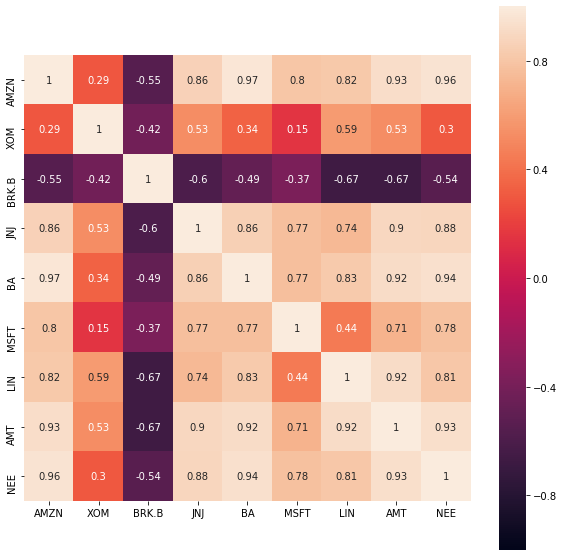

In [0]:
fig, ax = plt.subplots(figsize=(10, 10))

#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, annot=True, vmin=-1, square='True')

plt.show()

Now we ran analysis on industry data

In [0]:
def getIndustryData(filename):
    ind = pd.DataFrame()
    df = pd.read_csv(filename[0])
    indname = filename[0].split("Industries/")[1].split('.csv')[0]
    ind = df[['timestamp', 'close']]
    ind = ind.rename(columns={'close':indname})
    for i in range(1, len(filename)):
        df = pd.read_csv(filename[i])

        indname = filename[i].split("Industries/")[1].split('.csv')[0]
        data = df[['timestamp', 'close']]
        data = data.rename(columns={'close':indname})
        ind = pd.merge(ind, data, on='timestamp', how='outer')
    return ind

We calculate the correlation between industries. 

From the figure, we can see that the industries are highly correlated. In particular, financials has negative correlation with all the other industries. Information Technology and Energy sectors have weaker correlation with other industries. The reason might be those industries are less sensitive to overall market change. 

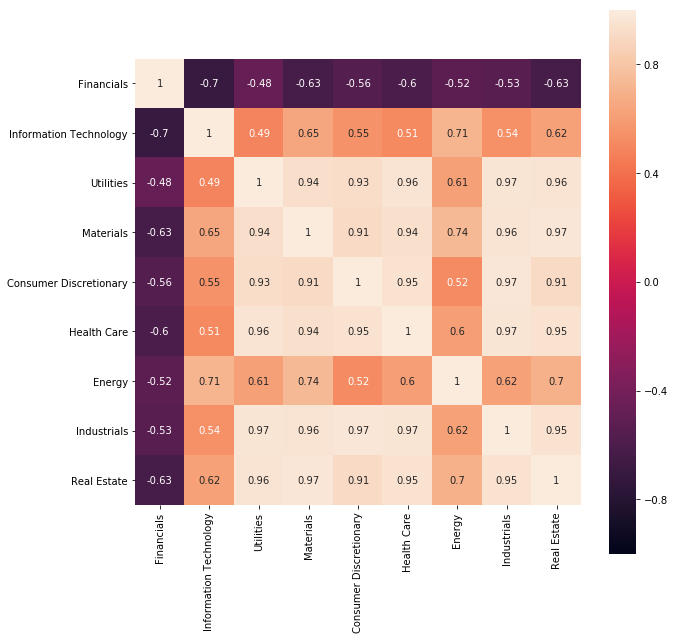

In [0]:
filename = glob.glob("./Industries/*.csv")

ind = getIndustryData(filename)

ind.set_index('timestamp', inplace=True)
ind = ind.sort_index()

corr_ind = ind.corr()


fig, ax = plt.subplots(figsize=(10, 10))

#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr_ind, annot=True, vmin=-1, square='True')

plt.show()

Time series Analysis
* We plot the trend over years for those stocks with maximum weight in each industry.
* Stocks like Amzn see a significant increase in their stock price over years.
* Other stocks like XOM flunctuates over years while the level of stock price does not change much. 

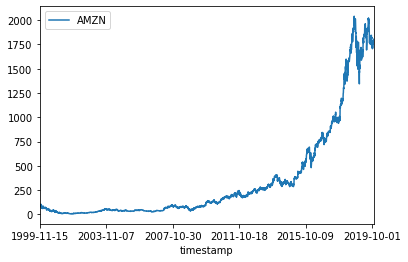

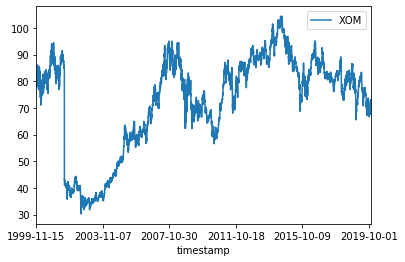

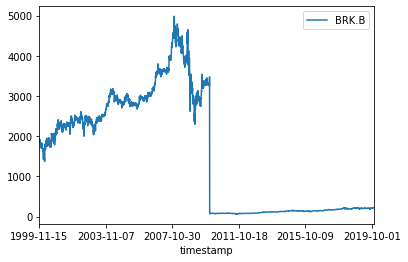

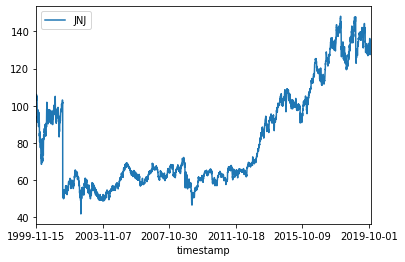

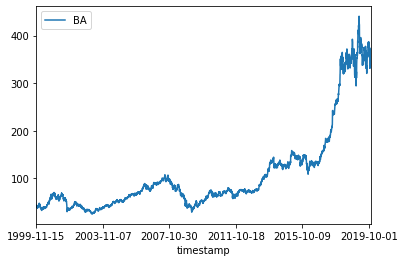

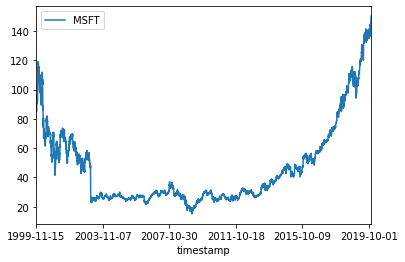

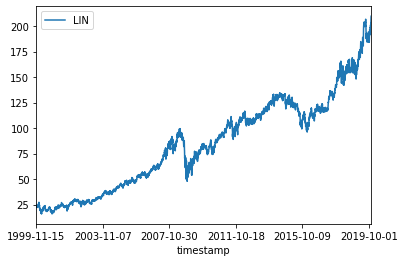

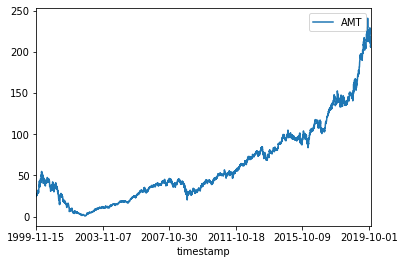

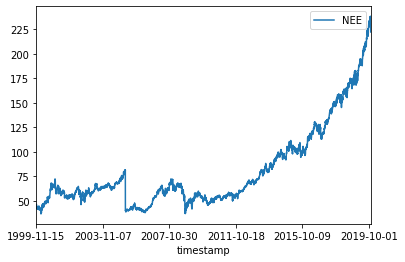

In [0]:
df3 = df3.reset_index()
for c in df3.columns:
    if c == 'timestamp':
        continue
    df3.plot(x = 'timestamp' , y =c)


Specifically, we plot the stock price over years for Microsoft and Google. We could vision that Microsoft's stock price remained stable across years while Google's stock price increased significantly. It is a good indication for growth of business. 

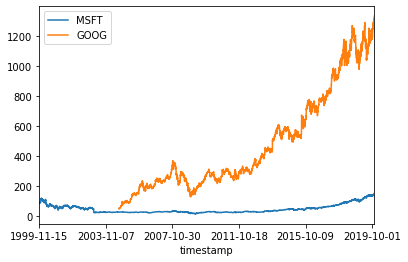

In [0]:
sreset = stocks.reset_index()
ax = plt.gca()
X = ['MSFT', 'GOOG']
for n in X:
    sreset.plot(x='timestamp',y=n,ax=ax)

plt.show()

In terms of stock return, we also look at the return we obtain from investing in Google vs. Microsoft. Clearly, the return for Microsoft is nearly zero while the return for Google is high.

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.]),
 <a list of 9 Text xticklabel objects>)

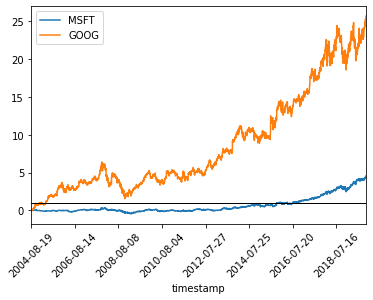

In [0]:
stock = stocks[['MSFT', 'GOOG']]
stock.dropna(inplace=True)
stock_return = stock.apply(lambda x: x / x[0] - 1)

fig, ax = plt.subplots()

stock_return.plot(ax=ax).axhline(y = 1, color = "black", lw = 1)
plt.xticks(rotation=45)

In [ ]:
! pip install fbprophet
from fbprophet import Prophet

### Facebook Prophet
* __Motivation__:  As a libary developed and maintained by __Facebook__, `Prophet` can be very handy for time series data prediction and have various capabilities including seasonality extraction, trend estimation etc.
* __Introduction__: `Prophet` is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.Prophet is open source software released by Facebook’s Core Data Science team. It is available for download on CRAN and PyPI.
* __Input__ : Prophet has sepecial requirement for the input formating. It only accept a dataframe with column __`ds` (time of the observation)__ and column __`y` (observation value)__. In this case, the stock's __`closing price`__ is the __`y`__ input while the __`date`__ is the __`ds`__ input.
* __Output__ : The output of prophet is an object that contains various contents including predicted values, seasonality extraction and trend extraction. Besides, a confidence interval is offered for every predicted value.
* __Result__ : Facebook Prophet generates a result that is similar to `ARIMA model`, which is a smooth trend with minor fluctuation.
<img src="images/Prophet.png" width = 600>
<br><center>(graph) Prophet Prediction for Amazon Stock</center>

In [0]:
def prophet (df):
    data = df[df.index > '2013-11-14']
    train_data = data[data.index < '2017-11-15']
    val_data = data[data.index > '2017-11-14']
  
  #creating dataframe
    new_data = pd.DataFrame(index=range(0,len(train_data)),columns=['date', 'close'])

  
    for i in range(0,len(train_data)):

        new_data['date'][i] = train_data.index[i]

        new_data['close'][i] = train_data['close'][i]

  

    new_data['date'] = pd.to_datetime(new_data.date,format='%Y-%m-%d')

    new_data.index = new_data['date']

  

    #preparing data

    new_data.rename(columns={'close': 'y', 'date': 'ds'}, inplace=True)

  

    #train and validation

    train = new_data

    valid = val_data



    #fit the model

    model = Prophet()

    model.fit(train)



    #predictions

    close_prices = model.make_future_dataframe(periods=len(valid))

    forecast = model.predict(close_prices)

    preds = forecast[forecast['ds'] > '2017-11-14'][['yhat']]

    rms=np.sqrt(np.mean(np.power((np.array(val_data['close'])-preds['yhat']),2)))

    preds = np.array(preds['yhat'])

    return preds,rms

Recurrent Network Function

In [ ]:
!pip install keras
!pip install tensorflow

### Recurrent Neural Network
* __Motivation__: Deep learning has become a hot field and neural network models can have superb peformance in many cases. `Recurrent neural network (RNN)` is a class of models that fit for __time-seires fashioned__ data.
<br>
* __Introduction__: In this stock prediction case, we use `Long short-term memory (LSTM)`, which is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points (such as images), but also entire sequences of data (such as stock price series). 
* __Input__ : We use a network with two 50 units LSTM layers as our model. The input of LSTM network in this use case is __stock price sequence data__. We use `60` days look back window to create the input price sequence. That being said, each input of the model is a sequence of prices for one stock in 60 days.
* __Output__ : Each output from the model should be one stock price point in the future. The model will take stock prices of the past 60 days to predict tomorrow's price
* __Result__ : LSTM was able to generate a smooth trend at the begining. However, as we are predicting for two years, the LSTM needs to take its predictions as input to perform further preidiction. Therefore, the predicted values become flatten eventually. Besides, we observed LSTM was realtively computationally expensive (It took about 5 minutes for each epoch) and generated unstable results
<img src="images/LSTM.png" width = 600>
<br><center>(graph) LSTM Prediction for Amazon Stock</center>

In [0]:
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential

from keras.layers import Dense, Dropout, LSTM


def network(df):
  #creating dataframe

    data = df[df.index > '2013-11-14'].sort_index(ascending=True, axis=0)

    new_data = pd.DataFrame(index=range(0,len(data)),columns=['Date', 'Close'])

    for i in range(0,len(data)):

        new_data['Date'][i] = data.index[i]

        new_data['Close'][i] = data['close'][i]

  

    #setting index

    new_data.index = new_data.Date

    new_data.drop('Date', axis=1, inplace=True)





    dataset = new_data.values

    train = new_data[new_data.index < '2017-11-15'].values

    valid = new_data[new_data.index > '2017-11-14'].values



    #converting dataset into x_train and y_train

    scaler = MinMaxScaler(feature_range=(0, 1))

    scaled_data = scaler.fit_transform(train)



    x_train, y_train = [], []

    for i in range(60,len(train)):

        x_train.append(scaled_data[i-60:i,0])

        y_train.append(scaled_data[i,0])

    x_train, y_train = np.array(x_train), np.array(y_train)



    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))



    # create and fit the LSTM network

    model = Sequential()

    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))

    model.add(LSTM(units=50))

    model.add(Dense(1))



    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(x_train, y_train, epochs=2, batch_size=1, verbose=0)

    # No data feed. Predict based on past predictions

    inputs = new_data[len(new_data) - len(valid) - 60: len(new_data) - len(valid) ].values

    inputs = inputs.reshape(-1,1)

    inputs  = scaler.transform(inputs)

    predictions = []

    for i in range(60,len(valid) + 60):

        pred = model.predict(np.array([inputs]))[0][0]
        inputs = np.append(inputs,pred)[-60:,np.newaxis]
        predictions.append(pred)


    preds = scaler.inverse_transform(np.array([predictions]))[0]

    val_data = data[data.index > '2017-11-14']
    rms=np.sqrt(np.mean(np.power((np.array(val_data['close'])-preds),2)))

    return preds, rms
 

### Linear Regression 
* __Motivation__: Linear regression is the simplest machine learning model that could be implemented on the data set.  With linear regression, the model generates a linear equation that depicts the relationship between stock price and feature variables. 
<br>
* __Introduction__: For linear regression, it predicts the relationship between change in response variable and change in independent variables (features). In our case, the response variable is __stock price__.
* __Input__ : The input is time series of stock price from 2013-11-15 to 2017-11-14. Specifically, dates. We need to extract more meaningful features instead of only using "Date" as our feature. In our implementation, we extracted features like day of the week, day of the month, month of the year, etc. We utilized a package called [fastai](https://docs.fast.ai/install.html) to automate the feature engineering. __add_datepart__ will generate those features for you. This will generate features: 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', and 'Is_year_start'.
* __Output__ : Output is prediction of stock price. 

* __Result__ : The RMSE value is high. By visualizing the data, we could see that the prediction values are "off" by a certain amount. However, the increasing trend for the stock price is correct. From linear regression model, we infer that such simple model can capture certain characteristics of time series prediction. However, we might overfit on features like month and date. Our model assigns the same value for the same date one month ago and the date one year ago, which may not be reasonable. 
<img src="images/LR.png" width = 600>
<br><center> Linear Regression Prediction for Amazon Stock</center>

In [ ]:
!pip install fastai==0.7.0

In [0]:
from fastai.structured import  add_datepart
def generateFeatures(data):
    #creating a separate dataset

    new_data = data[['Date', 'close']]



    #create features

    add_datepart(new_data, 'Date')

    new_data.drop('Elapsed', axis=1, inplace=True) 

    new_data['mon_fri'] = 0

    for i in range(0,len(new_data)):

        if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):

            new_data['mon_fri'][i] = 1

        else:

            new_data['mon_fri'][i] = 0  

    return new_data


In [0]:
from sklearn.linear_model import LinearRegression


def LR(data):
    data = data.reset_index()
    data['Date'] = pd.to_datetime(data.timestamp,format='%Y-%m-%d')

    data.index = data['Date']
    #sorting


    data = data.sort_index(ascending=True, axis=0)

    new_data = generateFeatures(data)



    ## train 
    train_data = new_data[new_data.index < '2017-11-15']
    mask = new_data.index > '2017-11-14'
    val_data = new_data[mask]


    #split into train and validation

    x_train = train_data.drop('close', axis=1)

    y_train = train_data['close']

    x_valid = val_data.drop('close', axis=1)

    y_valid = val_data['close']

    #implement linear regression



    model = LinearRegression()

    model.fit(x_train,y_train)

    #make predictions and find the rmse

    preds = model.predict(x_valid)

    rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))


    return preds, rms 

### KNN
* __Motivation__: Another traditional machine learning algorithm is KNN (K nearest neighbors). KNN can find similarities between old data and new data points, which may capture some changes under specific circumstances.
<br>
* __Introduction__: The simplest approach of KNN regression is to calculate the average value of the response variable from its K nearest neighbors. Choosing the optimal value of K can be done through __grid-search__. In our implementation, we search from 2 nearest neighbors to 9 nearest neighbors to find the best outcome.
* __Input__ : The input is time series of stock price from 2013-11-15 to 2017-11-14. Specifically, dates. We need to extract more meaningful features instead of only using "Date" as our feature. In our implementation, we extracted features like day of the week, day of the month, month of the year, etc. We utilized a package called fastai to automate the feature engineering part. __add_datepart__ will generate those features for you. This will generate features: 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', and 'Is_year_start'. Since scale matters a lot in calculating distance, we __normalize__ the features before doing a train test split. 
* __Output__ : Output is prediction of stock price. 

* __Result__ : The RMSE value is high than linear regression. By visualizing the data, we could see that the prediction values are average of the previous data. That's the reason why the overall prediction is lower than the actual stock price. However, as shown in the figure, KNN can capture non-linear patterns (for instance, seasonal changes) in the time series data.
<img src="images/KNN.png" width = 600>
<br><center> KNN Regression Prediction for Amazon Stock</center>

In [0]:
from sklearn import neighbors

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler

def KNN(data):


    scaler = MinMaxScaler(feature_range=(0, 1))
    data = data.reset_index()
    data['Date'] = pd.to_datetime(data.timestamp,format='%Y-%m-%d')

    data.index = data['Date']
    #sorting


    data = data.sort_index(ascending=True, axis=0)

    new_data = generateFeatures(data)



    ## train 
    train_data = new_data[new_data.index < '2017-11-15']
    mask = new_data.index > '2017-11-14'
    val_data = new_data[mask]


    #split into train and validation

    x_train = train_data.drop('close', axis=1)

    y_train = train_data['close']

    x_valid = val_data.drop('close', axis=1)

    y_valid = val_data['close']
    
    #scaling data

    x_train_scaled = scaler.fit_transform(train_data)

    x_train = pd.DataFrame(x_train_scaled)

    x_valid_scaled = scaler.fit_transform(val_data)

    x_valid = pd.DataFrame(x_valid_scaled)
    
    


    #using gridsearch to find the best parameter

    params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

    knn = neighbors.KNeighborsRegressor()



    model = GridSearchCV(knn, params, cv=5)



    #fit the model and make predictions

    model.fit(x_train,y_train)

    preds = model.predict(x_valid)  

    rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))



    return preds, rms

### Moving Average
* __Motivation__: `Moving Average` is a simple model used as a baseline to compare the performance of other models against.
<br>
* __Introduction__: In `Moving Average`, we compute the predictions by looking at the previous `n` data points and calculating their average. This serves as the first prediction. This prediction is then used in the making the next prediction and so on till we make predictions for all the data points in the validation set. 
* __Input__: The input of `Moving Average` in this use case is __stock price close value__. We use `n` days (size of validation data) look back window to create the input price sequence.
* __Output__: Each output from the model should be one stock price point in the future. The model will take stock prices of the past `n` days to predict tomorrow's price.
* __Result__: We see that the `Moving Average` model doesn't do a great job in predicting the prices or the trends.
<img src="images/MA.png" width = 600>
<br><center>(graph) Moving Average Prediction for Amazon Stock</center>

In [0]:
def moving_average(df):
    data = df[df.index > '2013-11-14']
    data.index = pd.to_datetime(data.index)
    new_data = pd.DataFrame(index = range (0, len(data)), columns = ['Date', 'Close'])

    for i in range (0, len(data)):
        new_data['Date'][i] = data.index[i]
        new_data['Close'][i] = data['close'][i]
        
    new_data.set_index('Date', inplace=True)
    new_data = new_data.sort_index()
    
    train_data = new_data[new_data.index < '2017-11-15']
    mask = new_data.index > '2017-11-14'
    val_data = new_data[mask]
    
    preds = []
    n = len(val_data)
    for i in range (0,n):
        a = train_data['Close'][len(train_data)-n + i:].sum() + sum(preds)
        b = a / n
        preds.append(b)
    
    rms = np.sqrt(np.mean(np.power((np.array(val_data['Close'])-preds),2)))

    preds = np.asarray(preds)
    
    return preds, rms

### ARIMA
* __Motivation__: `ARIMA` is short for 'Auto Regressive Integrated Moving Average'. It is a powerful time-series model that helps find trends in any given __time-series fashioned__ data.
<br>
* __Introduction__: `ARIMA` is actually a class of models that 'explains' a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values. 
* __Input__: The input of `ARIMA` in this use case is __stock price close value__. 
* __Output__: Each output from the model should be one stock price point in the future. We decide the number of forecast periods we want and we set it equal to the length of the validation data.
* __Result__: We see that the `ARIMA` model performs the best out of all the other models and the predictions made by it are pretty close to the actual values.
<img src="images/ARIMA.png" width = 600>
<br><center>(graph) ARIMA Prediction for Amazon Stock</center>

In [0]:
from statsmodels.tsa.arima_model import ARIMA

In [0]:
def arima_model(df):
    data = df[df.index > '2013-11-14']
    data.index = pd.to_datetime(data.index)
    new_data = pd.DataFrame(index = range (0, len(data)), columns = ['Date', 'Close'])

    for i in range (0, len(data)):
        new_data['Date'][i] = data.index[i]
        new_data['Close'][i] = data['close'][i]
        
    new_data.set_index('Date', inplace=True)
    new_data = new_data.sort_index()
    
    train_data = new_data[new_data.index < '2017-11-15']
    mask = new_data.index > '2017-11-14'
    val_data = new_data[mask]

    training = np.asarray(train_data['Close'])

    validation = val_data['Close']

    model = ARIMA(training,order=(0,1,0))
    model = model.fit()

    forecast = model.forecast(steps = len(val_data))[0]
    



    rms = np.sqrt (np.mean (np.power ((np.array (val_data['Close'])-forecast), 2)))


    return forecast, rms

## Model Benchmarking

In this part, we will run predictive models we mentioned above on top 10 stocks of each industry:
* Industrials
* Health Care
* Information Technology
* Consumer Discretionary
* Utilities
* Financials
* Materials
* Real Estate
* Energy

We rank stocks of each industry by their __`weights`__ for the _S&P 500 Index_. The __`weights`__ were loaded in the __Data Preprocessing__ Section.
 
In the following box, we created index dictionaries to select top 10 stocks for each industry and create stock-industry mapping

In [0]:
# Select the top 10 stocks for each industry with enough data as the model input
top_10_stocks = []
top_10_stock_industry_dict = {}
for industry,stocks in reverse_industries_dict.items():
    weights = {}
    for stock in stocks:
        if stock in model_inputs:
            weights[stock] = weights_dict[stock]
    top_10 = sorted(weights, key=weights.get, reverse=True)[:10]
    top_10_stocks += top_10
    top_10_stock_industry_dict[industry] = top_10

Now let's fit 6 models on top 10 stocks of all industries. The process took about 7 hours on AWS and the major bottleneck is training the LSTM.

In [0]:
total = len(top_10_stocks)
output = {}
start_time = time.perf_counter()
for i,stock in enumerate(top_10_stocks):  
    df = data_dict[stock]
    result = {}
    result['LR'] = LR(df)
    result['MA'] = moving_average(df)
    result['ARIMA'] = arima_model(df)
    result['LSTM'] = network(df)
    result['Prophet'] = prophet(df)
    result['KNN'] = KNN(df)
    output[stock] = result
    curr_time = time.perf_counter()
    elapse = curr_time - start_time
    print("{} / {} time: {} out of {}".format(i,total,elapse,total * elapse / (i+1)))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0 / 90 time: 281.3576441750047 out of 25322.18797575042


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1 / 90 time: 559.9373552000034 out of 25197.18098400015


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



2 / 90 time: 840.5144437029958 out of 25215.433311089873


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



3 / 90 time: 1118.45849807997 out of 25165.316206799325


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


4 / 90 time: 1396.405550417956 out of 25135.299907523207


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5 / 90 time: 1676.0098068619845 out of 25140.147102929768


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



7 / 90 time: 2240.1707743649604 out of 25201.921211605804


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


8 / 90 time: 2522.6187698299764 out of 25226.187698299764


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



9 / 90 time: 2804.3972973659984 out of 25239.575676293985


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10 / 90 time: 3087.7262555949856 out of 25263.214818504428


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



11 / 90 time: 3370.8869233859587 out of 25281.65192539469


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



12 / 90 time: 3655.5297118029557 out of 25307.513389405078


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



13 / 90 time: 3938.381218087976 out of 25318.164973422703


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


14 / 90 time: 4223.271015527949 out of 25339.626093167695


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



15 / 90 time: 4509.01508067298 out of 25363.20982878551


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


16 / 90 time: 4795.417513261957 out of 25387.504481975066


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



17 / 90 time: 5079.744758593966 out of 25398.72379296983


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



18 / 90 time: 5365.6597008549725 out of 25416.282793523555


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


19 / 90 time: 5652.778805885988 out of 25437.504626486945


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


20 / 90 time: 5939.105443573964 out of 25453.309043888417


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


21 / 90 time: 6228.159430653963 out of 25478.834034493484


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



22 / 90 time: 6515.362171228975 out of 25494.89545263512


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


23 / 90 time: 6803.299793955986 out of 25512.37422733495


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


24 / 90 time: 7089.477419502975 out of 25522.11871021071


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


25 / 90 time: 7378.218944405962 out of 25539.988653712946


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


26 / 90 time: 7666.837793117971 out of 25556.125977059903


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


27 / 90 time: 7956.373979710974 out of 25574.05922049956


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


28 / 90 time: 8244.82479506795 out of 25587.38729503847


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



29 / 90 time: 8535.743395967991 out of 25607.230187903973


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


30 / 90 time: 8828.101116982987 out of 25629.970984789317


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


31 / 90 time: 9119.670744295 out of 25649.073968329685


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


32 / 90 time: 9413.64817449695 out of 25673.585930446225


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



33 / 90 time: 9707.045885125 out of 25695.121460625


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



34 / 90 time: 9998.004355669953 out of 25709.154057437023


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



35 / 90 time: 10291.165344640962 out of 25727.913361602405


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


36 / 90 time: 10585.764346585958 out of 25749.1565187226


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



37 / 90 time: 10879.695576397004 out of 25767.700049361323


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


38 / 90 time: 11173.410542508995 out of 25784.793559636142


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


39 / 90 time: 11464.88375379995 out of 25795.988446049887


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



40 / 90 time: 11761.123044391978 out of 25817.099365738486


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


41 / 90 time: 12055.774471163983 out of 25833.802438208535


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



42 / 90 time: 12350.265886745998 out of 25849.393716445113


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


43 / 90 time: 12648.161601073982 out of 25871.23963856042


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


44 / 90 time: 12944.650318372005 out of 25889.300636744014


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


45 / 90 time: 13244.486492225959 out of 25913.125745659483


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



46 / 90 time: 13542.098783017951 out of 25931.67852067267


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



47 / 90 time: 13841.309192776971 out of 25952.454736456817


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



48 / 90 time: 14139.91906294995 out of 25971.279911540725


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


49 / 90 time: 14439.55402945896 out of 25991.197253026123


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


50 / 90 time: 14739.83627065795 out of 26011.475771749323


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


51 / 90 time: 15040.789570132969 out of 26032.135794460908


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


52 / 90 time: 15344.413733891968 out of 26056.551623590134


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



53 / 90 time: 15642.996874551987 out of 26071.661457586644


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


54 / 90 time: 15947.263639803976 out of 26095.522319679232


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


55 / 90 time: 16248.335275511956 out of 26113.395978501358


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


56 / 90 time: 16550.97640196397 out of 26133.12063467995


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



57 / 90 time: 16855.09497566399 out of 26154.457720857918


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


58 / 90 time: 17157.878757610975 out of 26173.035392965892


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


59 / 90 time: 17460.891211562965 out of 26191.33681734445


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



60 / 90 time: 17766.15448373696 out of 26212.359074366002


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


61 / 90 time: 18070.143978990964 out of 26230.854163051397


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


62 / 90 time: 18374.57186395797 out of 26249.388377082814


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


63 / 90 time: 18682.69227762596 out of 26272.536015411504


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


64 / 90 time: 18988.370950642973 out of 26291.590547044118


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



65 / 90 time: 19294.937016302953 out of 26311.277749504025


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



66 / 90 time: 19602.601979948 out of 26331.853405900296


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



67 / 90 time: 19910.699531403952 out of 26352.396438622876


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


68 / 90 time: 20222.751389493 out of 26377.501812382176


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


69 / 90 time: 20528.734466602968 out of 26394.087171346673


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


70 / 90 time: 20838.447494644963 out of 26414.933443916147


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


71 / 90 time: 21150.269728338986 out of 26437.837160423733


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


72 / 90 time: 21463.467305698956 out of 26461.80900702611


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


73 / 90 time: 21774.273426206957 out of 26482.22443727873


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



74 / 90 time: 22085.732100999972 out of 26502.878521199964


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


75 / 90 time: 22396.83376064396 out of 26522.566295499426


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


76 / 90 time: 22708.830019932997 out of 26542.788334986617


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


77 / 90 time: 23021.30021739495 out of 26563.038712378788


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


78 / 90 time: 23335.864209096995 out of 26585.161757199105


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



79 / 90 time: 23648.49824834999 out of 26604.560529393737


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


80 / 90 time: 23964.110146260995 out of 26626.78905140111


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


81 / 90 time: 24280.94190798397 out of 26649.814289250702


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


82 / 90 time: 24598.62113257096 out of 26673.203637727547


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



83 / 90 time: 24911.749384961964 out of 26691.16005531639


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


84 / 90 time: 25230.452906149963 out of 26714.597194747017


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


85 / 90 time: 25546.81840509799 out of 26735.042516963014


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


86 / 90 time: 25865.90280531795 out of 26757.830488259948


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



87 / 90 time: 26185.23116397095 out of 26780.3500540612


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



88 / 90 time: 26506.336694895 out of 26804.160702702808


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


89 / 90 time: 26825.782866558002 out of 26825.782866558002


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



Here is a visualization function that can visualize different models' predictions for a certain stock:

In [0]:
def plot(df,preds):
  
    data = df[df.index > '2013-11-14'].sort_index(ascending=True, axis=0)

    data.index = pd.to_datetime(data.index) 

    train_data = data[data.index < '2017-11-15']

    val_data = data[data.index > '2017-11-14']

    val_data['Predictions'] = preds

    plt.plot(train_data['close'], label="train")

    plt.plot(val_data['close'], label="actual")

    plt.plot(val_data['Predictions'], label="predicted")

    plt.legend()
    
    plt.show()

def visualize(stock_code,output):
    print('Predictions for company {}'.format(stock_code))
    for model,result in output[stock_code].items():
        print("Prediction from {} model".format(model))
        plot(data_dict[stock_code],result[0])

Let's visualize our predictions for __`Exelon(EXC)`__. An American Fortune 100 energy company headquartered in Chicago, Illinois.

Predictions for company EXC
Prediction from LR model


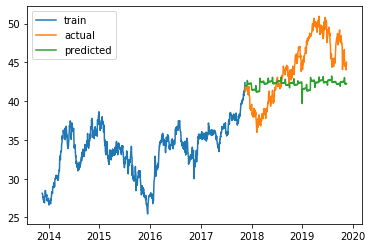

Prediction from MA model


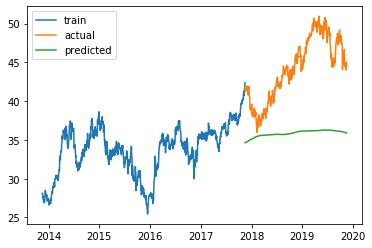

Prediction from ARIMA model


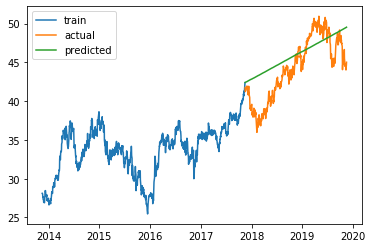

Prediction from LSTM model


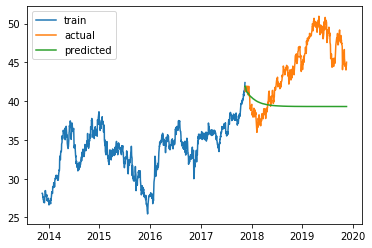

Prediction from Prophet model


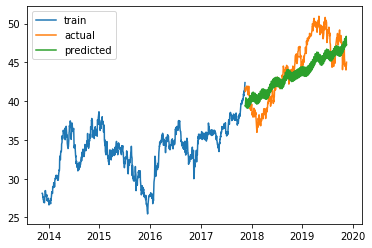

Prediction from KNN model


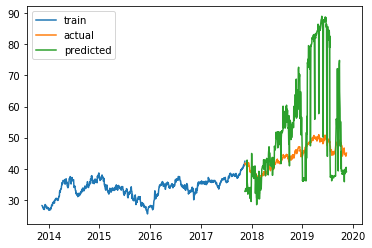

In [0]:
# Let's visualize our predictions for Amazon
visualize('EXC',output)

In [0]:
overall_mse = collections.defaultdict(list)
industry_mse = collections.defaultdict(lambda : collections.defaultdict(list))
MODELS = ['LR','MA','ARIMA','LSTM','Prophet','KNN']
for stock,results in output.items():
    industry = industries_dict[stock]
    for model in MODELS:
        preds = results[model][0]
        mse = results[model][1]
        norm_mse = mse / np.mean(preds)
        if norm_mse < 0:
            continue
        overall_mse[model].append(norm_mse)
        industry_mse[industry][model].append(norm_mse)

In [0]:
# Format the printing
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [0]:
for model in MODELS:
    mse = np.mean(overall_mse[model])
    mse_var = np.var(overall_mse[model])
    print("The overall MSE for model {} is: {:.2f} with a variance as {:.2f}".format(model,mse,mse_var))

The overall MSE for model LR is: 0.50 with a variance as 0.36
The overall MSE for model MA is: 0.32 with a variance as 0.05
The overall MSE for model ARIMA is: 0.20 with a variance as 0.04
The overall MSE for model LSTM is: 0.57 with a variance as 0.75
The overall MSE for model Prophet is: 0.22 with a variance as 0.01
The overall MSE for model KNN is: 0.76 with a variance as 0.26


In [0]:
for industry,mses in industry_mse.items():
    print(color.BOLD + "For {} industry".format(industry) + color.END)
    best_mse = 1e10
    best_model = ""
    for model in MODELS:
        mse = np.mean(mses[model])
        mse_var = np.var(mses[model])
        print("The MSE for model {} is: {:.2f} with a variance as {:.2f}".format(model,mse,mse_var))
        if mse < best_mse:
            best_mse = mse
            best_model = model
    print("{} model has the best performance for {} industry with an average MSE as {:.2f}\n".format(best_model,industry,best_mse))

For Industrials industry
The MSE for model LR is: 0.44 with a variance as 0.11
The MSE for model MA is: 0.36 with a variance as 0.06
The MSE for model ARIMA is: 0.19 with a variance as 0.01
The MSE for model LSTM is: 0.42 with a variance as 0.11
The MSE for model Prophet is: 0.22 with a variance as 0.02
The MSE for model KNN is: 0.91 with a variance as 0.22
ARIMA model has the best performance for Industrials industry with an average MSE as 0.19

For Health Care industry
The MSE for model LR is: 0.55 with a variance as 0.11
The MSE for model MA is: 0.29 with a variance as 0.03
The MSE for model ARIMA is: 0.17 with a variance as 0.01
The MSE for model LSTM is: 0.41 with a variance as 0.11
The MSE for model Prophet is: 0.20 with a variance as 0.00
The MSE for model KNN is: 0.75 with a variance as 0.20
ARIMA model has the best performance for Health Care industry with an average MSE as 0.17

For Information Technology industry
The MSE for model LR is: 1.29 with a variance as 1.65
The MSE 

## Conclusion
__EDA__:
* Overall, stocks in financial industry have a negative correlation with stocks in other industries.
* Information Technology and Energy sectors are less sensitive to the overall market performance.


__Predictive Model__:
* Predictions by Linear based models (ARIMA, Linear Regression, Prophet) are closer to the actual stock prices.
* Non-linear models have relatively unsteady performance. However, they have advantages in certain aspects (LSTM can get a very low RMSE while KNN captured the trend well)
* Overall, __ARIMA__ has the best performance with the __lowest mean squared error (MSE)__. While for some industries (`Materials` and `Information Technology`), __Prophet__'s performance is slightly better.
* The complexity for stock price predcition in different industries varies. Overall, predictive models have worse performance for `Information Technology` and `Consumer Discretionary` industries than `Utilities`, `Real Estate` and `Financials` industries.